In [1]:
import pandas as pd
import torch
import importlib

#%load_ext line_profiler

In [2]:
from model.eGauss_plus import eGAUSSp

Client 1: {1: 10, 2: 15}
Client 2: {0: 22, 2: 9}
Client 3: {0: 12, 1: 24, 2: 13}
Test Set: {0: 16, 1: 16, 2: 13}

Combined Number of Samples per Class:
Class 0: 50 samples
Class 1: 50 samples
Class 2: 50 samples

Total Number of Samples Across All Datasets: 150


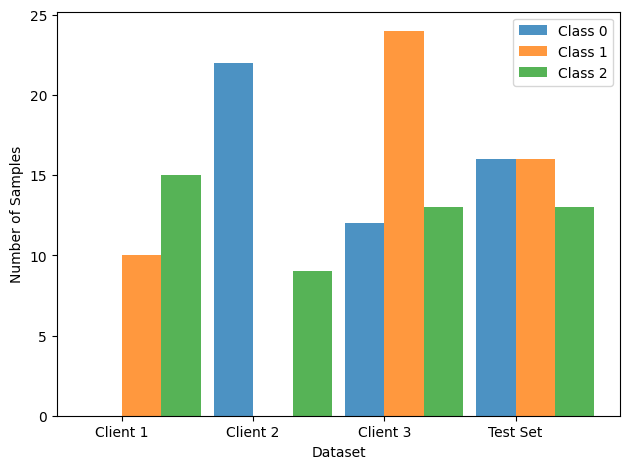

In [3]:
from utils.utils_dataset import prepare_non_iid_dataset, plot_dataset_split, display_dataset_split
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris()

X = iris.data
y = iris.target

num_clients = 3
train_data, test_data, all_data = prepare_non_iid_dataset(X, y, num_clients)

display_dataset_split(train_data, test_data)
plot_dataset_split(train_data, test_data)


In [4]:

# Model parameters
local_model_params = {
    "feature_dim": 4,
    "num_classes": 3,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 1.5,
    "S_0": 1e-8,
    "c_max": 4,
    "device": torch.device("cpu")
}
federated_model_params = {
    "feature_dim": 4,
    "num_classes": 3,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 2,
    "S_0": 1e-8,
    "c_max": 2,
    "device": torch.device("cpu")
}

# Initialize a model for each client
local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
federated_model = eGAUSSp(**federated_model_params)


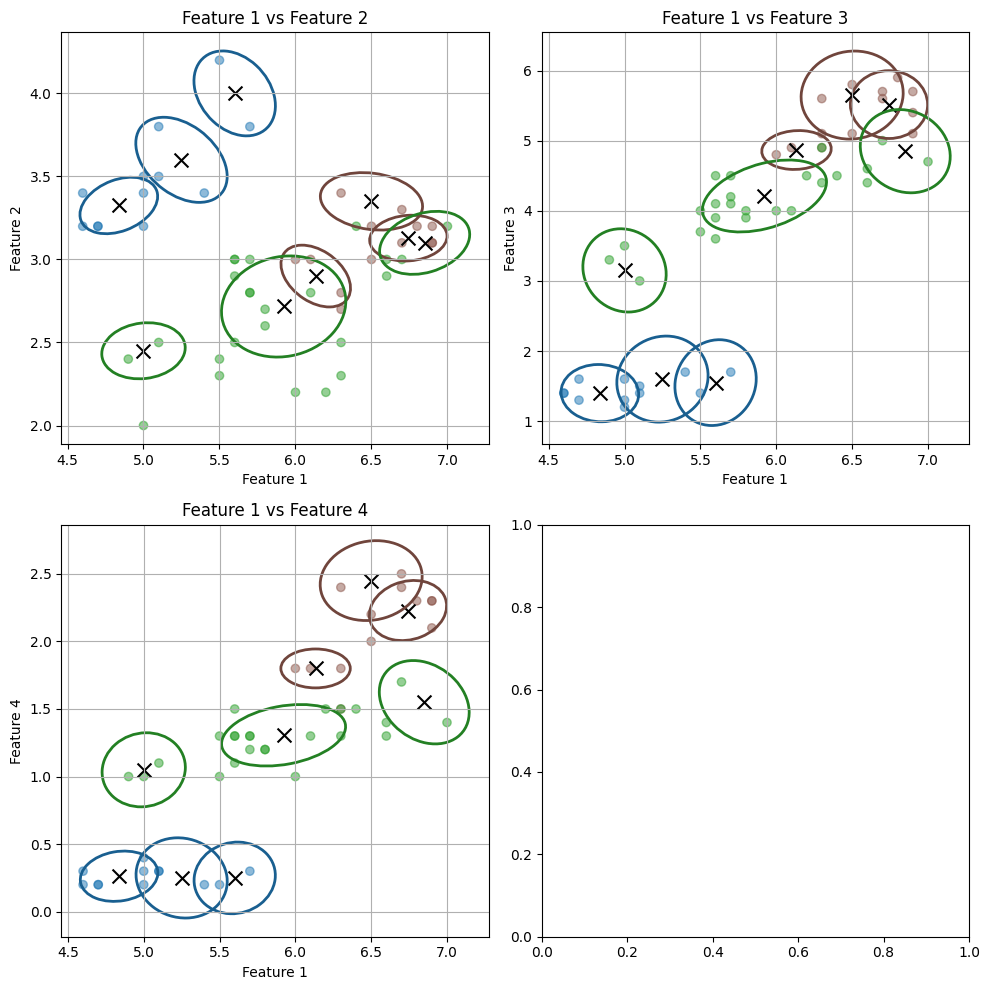

In [5]:
import utils.utils_train
importlib.reload(utils.utils_train)
from utils.utils_train import train_supervised, train_unsupervised
from utils.utils_plots import plot_first_feature

#Supervised clustering
for client_idx, client_model in enumerate(local_models):
    print(f"Training model for client {client_idx + 1}")
    train_supervised(client_model, train_data[client_idx]) 
    plot_first_feature(train_data[client_idx], model=client_model, num_sigma=2, N_max=1)  


In [6]:
from utils.utils_train import test_model   

# Testing each client's model on the global test dataset
for client_idx, client_model in enumerate(local_models):
    print(f"\nTesting model for client {client_idx + 1}")
    test_model(client_model, test_data)
    test_model(client_model, all_data)



Testing model for client 1
Evolving has been disabled.
Test Accuracy: 0.7555555555555555, Precision: 0.8551440329218107, Recall: 0.7555555555555555, F1 Score: 0.745839418791896
Evolving has been disabled.
Test Accuracy: 0.72, Precision: 0.8478260869565216, Recall: 0.72, F1 Score: 0.7007057717406768

Testing model for client 2
Evolving has been disabled.
Test Accuracy: 0.6444444444444445, Precision: 0.8243230625583567, Recall: 0.6444444444444445, F1 Score: 0.5279789767594646
Evolving has been disabled.
Test Accuracy: 0.6666666666666666, Precision: 0.8155864197530865, Recall: 0.6666666666666666, F1 Score: 0.5488233227959255

Testing model for client 3
Evolving has been disabled.
Test Accuracy: 0.8666666666666667, Precision: 0.8721693121693121, Recall: 0.8666666666666667, F1 Score: 0.8669841269841267
Evolving has been disabled.
Test Accuracy: 0.9066666666666666, Precision: 0.9092226613965744, Recall: 0.9066666666666666, F1 Score: 0.9067520442520441


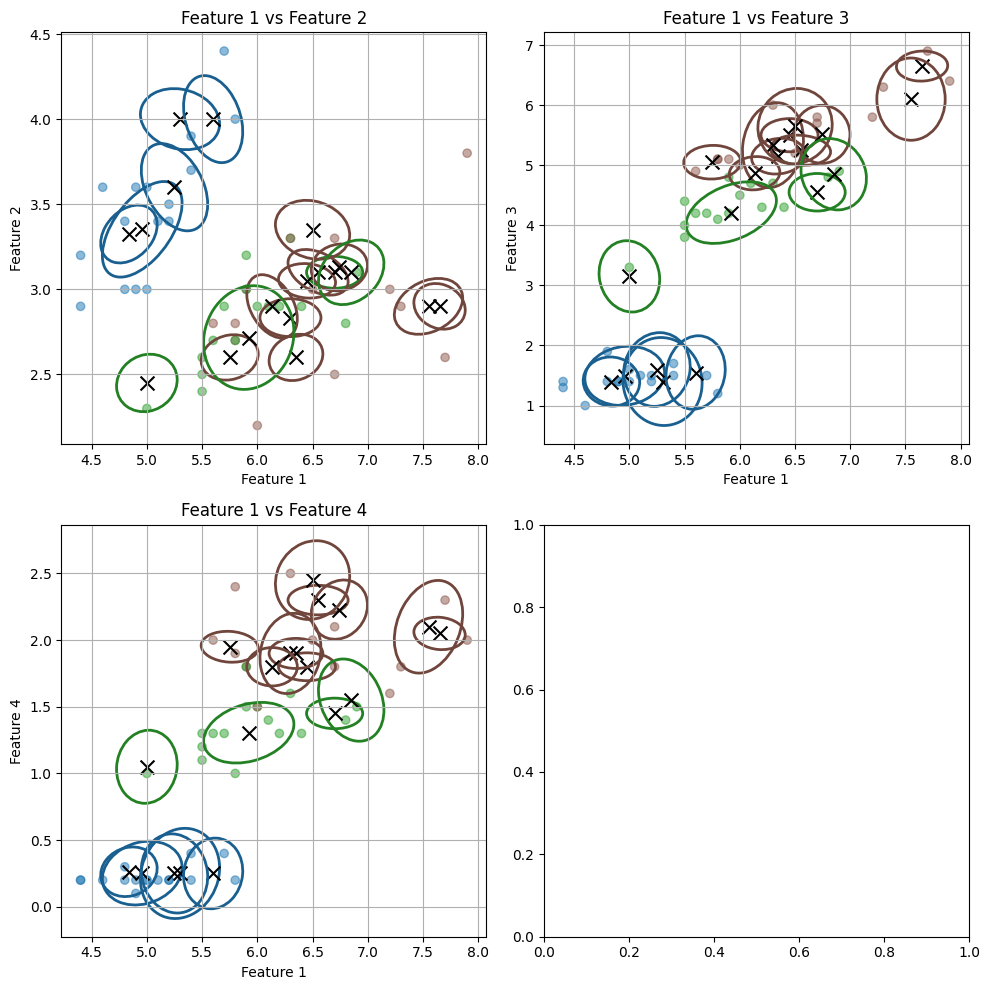

Number of clusters after transfer = 19


In [7]:
  
import utils.utils_train
importlib.reload(utils.utils_train)
from utils.utils_train import test_model


for client_idx, client_model in enumerate(local_models):
        print(f"Merging client {client_idx + 1}")
        federated_model.federal_agent.merge_model_privately(client_model,1)

plot_first_feature(test_data, model=federated_model, num_sigma=2, N_max=0)           

print(f"Number of clusters after transfer = {federated_model.c}")


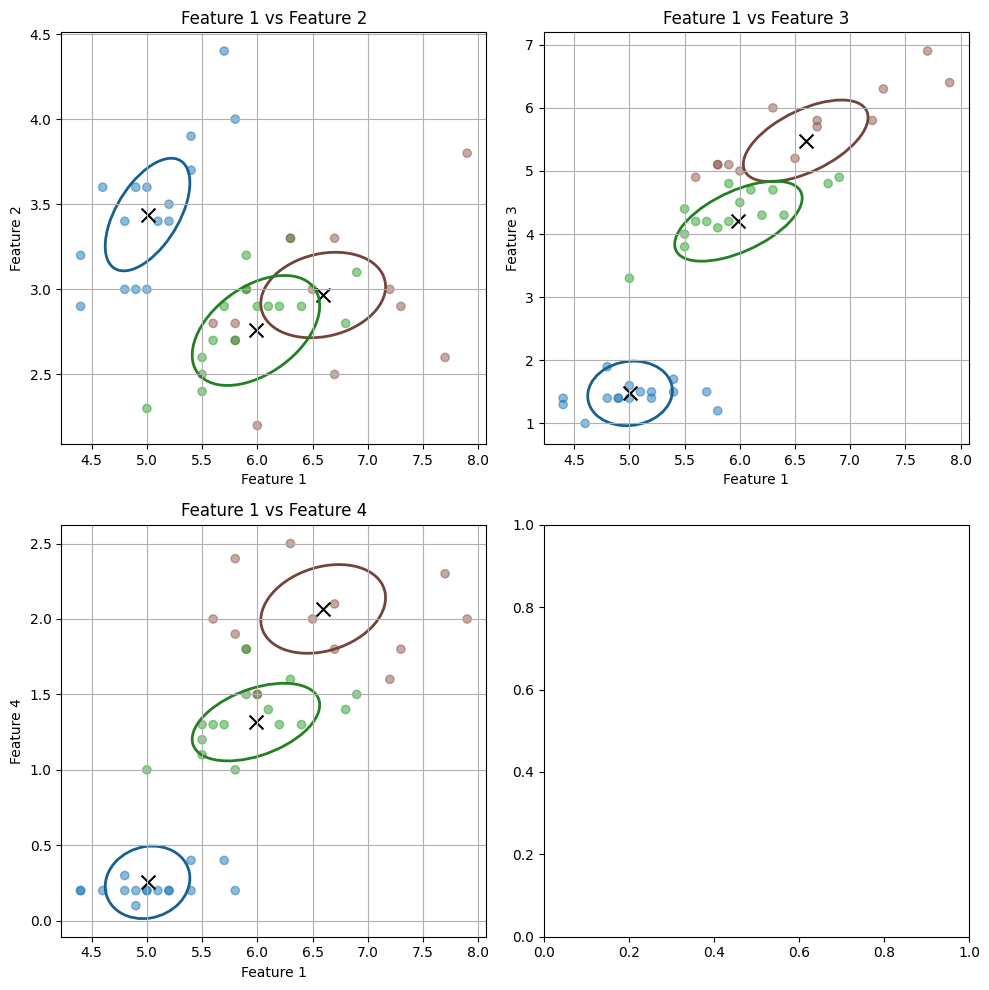

Number of clusters after merging = 3


In [8]:

federated_model.federal_agent.federated_merging()
plot_first_feature(test_data, model=federated_model, num_sigma=2, N_max=0)   
print(f"Number of clusters after merging = {federated_model.c}")

In [9]:

print(f"\nTesting federated model")   

test_model(federated_model, test_data)
test_model(federated_model, all_data)


Testing federated model
Evolving has been disabled.
Test Accuracy: 0.9555555555555556, Precision: 0.9555555555555556, Recall: 0.9555555555555556, F1 Score: 0.9555555555555556
Evolving has been disabled.
Test Accuracy: 0.9733333333333334, Precision: 0.9733333333333334, Recall: 0.9733333333333334, F1 Score: 0.9733333333333334
